# Cuaderno de Isac Añor Santana

## Paquetes necesarios

In [290]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

Fuentes de información:
- https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html
- https://docs.opencv.org/4.x/d1/d32/tutorial_py_contour_properties.html
- https://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary 

## TAREA 1: 
Captura una o varias imágenes con monedas no solapadas y algún objeto que no lo sea. Filtra los contornos que no se correpondan con monedas, y muestra el número total de monedas.

#### Inicialización

In [291]:
# Carga de la imagen
task_1_coins = cv2.imread("tarea1.jpg")

# Conversión a gris
task_1_grey = cv2.cvtColor(task_1_coins, cv2.COLOR_BGR2GRAY)

# Umbralizado OTSU invertido
ret, task_1_otsu = cv2.threshold(task_1_grey, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#### Procesamiento
Dibujará solamente los contornos externos de las monedas en una imagen vacía y contará el número de monedas (círculos)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


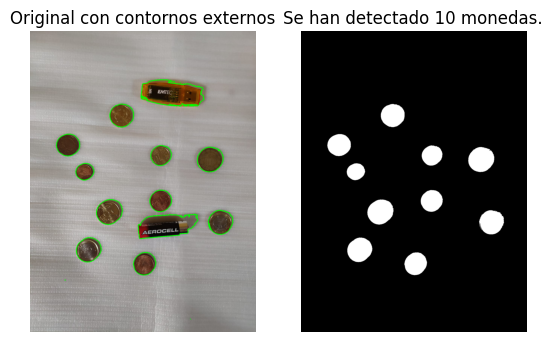

In [292]:
# Contornos externos, ideal para la tarea
external_contours, external_hierarchy = cv2.findContours(task_1_otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Se muestra la imagen original con los contornos externos detectados
task_1_coins_rgb = cv2.cvtColor(task_1_coins, cv2.COLOR_BGR2RGB)
cv2.drawContours(task_1_coins_rgb, external_contours, -1, (0,255,0), 3)

plt.subplot(121)
plt.axis("off")
plt.imshow(task_1_coins_rgb) 
plt.title('Original con contornos externos')

# Imagen vacía
coins_contours = np.zeros(task_1_coins.shape)
number_of_coins = 0
for contour in external_contours:
    # Área
    area = cv2.contourArea(contour)

    # Dimensión mínima
    if area > 10:
        # Perímetro
        perimeter = cv2.arcLength(contour, True)
        # Circulo mínimo que lo contiene
        (cx, cy), radius = cv2.minEnclosingCircle(contour)

        # Determinación de si el contorno que está siendo iterado es un círculo
        """
        La comparación se hace teniendo en cuenta lo siguiente:
        Dado que el área del cículo es pi*r**2 y el perímetro 2*pi*r, área/perímetro = r/2.
        Por lo tanto, se compara a ver si el radio/2 dado por minEnclosingCircle es similar a la 
        relación entre el área y el perímetro del contorno calculado.
        (Evidentemente, detecta círculos no solo monedas)
        """
        area_perimeter_relation = area/perimeter
        if radius/2 > area_perimeter_relation - radius/5 and radius/2 < area_perimeter_relation + radius/5:
            if contour.shape[0] > 5:
                elipse = cv2.fitEllipse(contour)
            #Dibuja los contornos
            cv2.drawContours(coins_contours, [contour], -1, (255,255,255), -1)
            number_of_coins += 1

plt.subplot(122)
plt.axis("off")
plt.title(f"Se han detectado {number_of_coins} monedas.")
plt.imshow(coins_contours)
plt.show()

## TAREA 2: 
Captura una o varias imágenes con monedas no solapadas, y otras con monedas solapadas. Identificada una moneda de un euro en la imagen, por ejemplo con un clic de ratón, calcular la cantidad de dinero presente en la imagen.




#### Inicialización

Como las imágenes originales son demasiado grandes, se procede a hacerles un reescalado, puesto que va a agilizar enormemente el desarrollo de la tarea

In [293]:
# Carga de la imagen
task_2_overlapped_coins = cv2.imread("tarea2.jpg")

cv2.imwrite("tarea_1_resized.jpg", cv2.resize(task_1_coins, (task_1_coins.shape[1]//2, task_1_coins.shape[0]//2), interpolation = cv2.INTER_AREA))
cv2.imwrite("tarea_2_resized.jpg", cv2.resize(task_2_overlapped_coins, (task_2_overlapped_coins.shape[1]//2, task_2_overlapped_coins.shape[0]//2), interpolation = cv2.INTER_AREA))

non_overlapped_img = cv2.imread("tarea_1_resized.jpg")
overlapped_img = cv2.imread("tarea_2_resized.jpg")

#### Procesamiento

##### Funciones auxiliares

In [294]:
def calculate_quantity(img, index, circles):
    euro_radius = circles[index][2]
    proportion_to_euro = [0.6993548387096775, 0.8064516129032258, 0.9139784946236559, 0.8494623655913979, 0.956989247311828, 1.043010752688172, 1.0, 1.10752688172043]
    values = {0.6993548387096775:0.01, 0.8064516129032258:0.02, 0.9139784946236559:0.05, 0.8494623655913979:0.1, 0.956989247311828:0.2, 1.043010752688172:0.5, 1.0:1.0, 1.10752688172043:2.0}
    quantity = 0
    for circle in circles:
        x, y, r = circle
        proportion = r/euro_radius
        key = 0
        min_diff = 100000
        for v in proportion_to_euro:
            diff = abs(proportion - v)
            if diff < min_diff:
                min_diff = diff
                key = v
        quantity += values[key]
        cv2.putText(img, f"{values[key]}", (int(x+r+10),int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0),2,2)
        #print(f"Valor de la moneda = {values[key]}, Proporcion={proportion}, x={x}, y={y}, min_diff={min_diff}, key={key}")
    print(f"Se han detectado {quantity} euros.\n")
    return None

In [295]:
def is_in_circle(x, y, circles):
    for index, circle in enumerate(circles):
        c_x, c_y, r = circle
        if (x - c_x)**2 + (y - c_y)**2 < r**2:
            return index
    return None

In [296]:
def handle_click(x, y, img, circles):
    is_circle = is_in_circle(x,y, circles[0])
    if is_circle != None:
        calculate_quantity(img, is_circle, circles[0])
        cx, cy, cr = circles[0][is_circle]
        cv2.circle(img, (int(cx), int(cy)), int(cr), (0,0,255),4)
    return img

In [297]:
def get_and_draw_circles(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Suaviza altas frecuencias
    pimg = cv2.medianBlur(gray_img, 7)

    # Localiza círculos
    circles = cv2.HoughCircles(
        pimg,
        cv2.HOUGH_GRADIENT,  # tipo de detección
        0.2,
        15,                  # distancia mínima entre círculos
        param1=100,          # Valor del gradiente
        param2=35,           # Umbral acumulador
        minRadius=5,        # radio mínimo
        maxRadius=100,       # radio máximo
    )

    # Los pinta sobre la imagen original
    for circle in circles[0]:
        x, y, r = circle
        cv2.circle(img, (int(x), int(y)), int(r), (0,255,0),2)
    
    return (img, circles)

##### Parte "principal"

Imagenes con círculos marcados y círculos detectados

In [298]:
outlined_non_overlapped_img, non_overlapped_img_circles = get_and_draw_circles(non_overlapped_img.copy())
outlined_overlapped_img, overlapped_img_circles = get_and_draw_circles(overlapped_img.copy())
"""
Muestra el resultado, mas bien para calibrar los parámetros de Hough.
plt.subplot(121)
plt.axis("off")
plt.imshow(outlined_non_overlapped_img)
plt.subplot(122)
plt.axis("off")
plt.imshow(outlined_overlapped_img)
"""

'\nMuestra el resultado, mas bien para calibrar los parámetros de Hough.\nplt.subplot(121)\nplt.axis("off")\nplt.imshow(outlined_non_overlapped_img)\nplt.subplot(122)\nplt.axis("off")\nplt.imshow(outlined_overlapped_img)\n'

In [299]:
# Carga de la imagen
task_2_overlapped_coins = cv2.imread("tarea2.jpg")

cv2.imwrite("tarea_1_resized.jpg", cv2.resize(task_1_coins, (task_1_coins.shape[1]//2, task_1_coins.shape[0]//2), interpolation = cv2.INTER_AREA))
cv2.imwrite("tarea_2_resized.jpg", cv2.resize(task_2_overlapped_coins, (task_2_overlapped_coins.shape[1]//2, task_2_overlapped_coins.shape[0]//2), interpolation = cv2.INTER_AREA))

non_overlapped_img = cv2.imread("tarea_1_resized.jpg")
overlapped_img = cv2.imread("tarea_2_resized.jpg")

In [300]:
cv2.imshow("Monedas no solapadas", outlined_non_overlapped_img)
cv2.imshow("Monedas Solapadas", outlined_overlapped_img)

# Se definen las funciones para gestionar los eventos de ratón
def non_overlapped_mouse_click(event, x, y, flags, param):
    # Click izquierdo
    if event == cv2.EVENT_LBUTTONDOWN:
        #print(non_overlapped_img_circles)
        clicked_img = handle_click(x,y, outlined_non_overlapped_img.copy(), non_overlapped_img_circles)
        cv2.imshow("Monedas no solapadas", clicked_img)

def overlapped_mouse_click(event, x, y, flags, param):
    # Click izquierdo
    if event == cv2.EVENT_LBUTTONDOWN:
        clicked_img = handle_click(x,y, outlined_overlapped_img.copy(), overlapped_img_circles)
        cv2.imshow("Monedas Solapadas", clicked_img)

# Se asignan los eventos a las dos imagenes que se van a mostrar
cv2.setMouseCallback('Monedas Solapadas', overlapped_mouse_click)
cv2.setMouseCallback('Monedas no solapadas', non_overlapped_mouse_click)

# Al pulsar una tecla cualquiera termina
cv2.waitKey(0)
# Cierra todas las ventanas
cv2.destroyAllWindows()

Observaciones:
La cuenta de monedas no es perfecta, he detectado que el fallo principal está centrado en la confusión de monedas de 50 céntimos con monedas de 2 euros y las de un

## TAREA 3: 
Estas tres imágenes han sido extraidas de las imágenes de mayor tamaño contenidas en la carpeta. Determina patrones geométricos para cada una de las tres clases y evalúa con las imágenes completas la matriz de confusión.

### Extracción de características

La extracción de características se llevará a cabo de la siguiente manera:
- Para cada imagen de referencia se extraen los contornos externos de los elementos
- Para cada contorno se calcula:
    * La relación del cuadrado del perímetro con el área
    * Relación del área con la del contenedor
    * Relación del ancho y el alto del contenedor
    * Relación entre los ejes de la elipse ajustada
    * La relación de aspecto del contenedor
    * La extensión como la relación entre el area del contorno y la del rectángulo delimitador
    * La solidez como la relación entre el área del contorno y el "casco" (hull)
    * Relación entre el perímetro y área para ver lo circular que es el contorno (medida de "circularidad")
    * Color o intensidad promedio de la zona del contorno
- Para simplificar, para cada una de las clases/microplásticos se computa un vector de características cuyos valores serán la media de los calculados para los contornos de referencia

In [301]:
def perimeter_area_ratio(contour):
    """Compactness of the blob, computed as the ratio between the square of the perimeter and the area."""
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    return perimeter**2/area

In [302]:
def blob_area_and_bounding_box_ratio(contour):
    """Ratio between the area of the blob and its bounding box."""
    blob_area = cv2.contourArea(contour)
    rect = cv2.minAreaRect(contour)
    width, height = rect[1]
    rect_area = width*height
    #print(f"Blob area = {area}.\t Min rect area = {rect_area}")
    return blob_area/rect_area

In [303]:
def bounding_box_width_and_height_ratio(contour):
    """Ratio between the width and the height of the blob bounding box."""
    rect = cv2.minAreaRect(contour)
    width, height = rect[1]
    return width/height

In [304]:
def fitted_ellipse_axises_ratio(contour):
    """Ratio between the major and minor axis of the fitted ellipse."""
    if len(contour) < 5:
        return 0
    ellipse = cv2.fitEllipse(contour)
    axis_1, axis_2 = ellipse[1]
    return axis_1/axis_2

In [305]:
def aspect_ratio(contour):
    """It is the ratio of width to height of bounding rect of the object."""
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = float(w)/h
    return aspect_ratio

In [306]:
def extent(contour):
    """Extent is the ratio of contour area to bounding rectangle area."""
    area = cv2.contourArea(contour)
    x,y,w,h = cv2.boundingRect(contour)
    rect_area = w*h
    extent = float(area)/rect_area
    return extent

In [307]:
def solidity(contour):
    """Solidity is the ratio of contour area to its convex hull area."""
    area = cv2.contourArea(contour)
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area)/hull_area
    return solidity

In [308]:
def circularity(contour):
    """The lower the value the closest to a circular shape"""
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    area_perimeter_ratio = area/perimeter
    (cx,cy), r = cv2.minEnclosingCircle(contour)
    return abs(area_perimeter_ratio - r/2)

In [309]:
def mean_colour(contour, img):
    """Average color/intensity"""
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = np.zeros(img_grey.shape,np.uint8)
    cv2.drawContours(mask,[contour],0,255,-1)
    pixelpoints = np.transpose(np.nonzero(mask))
    mean_val = cv2.mean(img_grey, mask = mask)
    return mean_val[0]

In [310]:
# Funciones que se encargan de hacer la extracción de una característica en particular
feature_extracting_functions = [
    perimeter_area_ratio,
    blob_area_and_bounding_box_ratio,
    bounding_box_width_and_height_ratio,
    fitted_ellipse_axises_ratio,
    aspect_ratio,
    extent,
    solidity,
    circularity,
    ]

In [311]:
def get_contour_feature_vector(contour, img):
    contour_feature_vector = [function(contour=contour) for function in feature_extracting_functions]
    contour_feature_vector.append(mean_colour(contour,img))
    return contour_feature_vector

In [312]:
def feature_extraction(microplastic_external_contours, img):
    # Lista que contendrá listas con los valores para cada característica de cada contorno
    features = [[] for _ in range(len(feature_extracting_functions)+1)]
    # Procesamiento para cada contorno
    for contour in microplastic_external_contours:
        # Se extraen las características
        feature_vector = get_contour_feature_vector(contour, img)
        # Se añaden al vector principal
        for i, feature_value in enumerate(feature_vector):
            features[i].append(feature_value)

    # Media de las características
    averaged_features = [sum(feature_list)/len(feature_list) for feature_list in features]
    return averaged_features

#### Incidencia: Detección de contornos no deseados
Realizando la detección de características me he encontrado con situaciones en las que el área del contorno es nula (división por cero). Algo preocupante puesto que demuestra que se están detectando contornos muy pequeños que no se corresponden con el elemento microplástico, objeto de interés.

Esto se puede visualizar descomentando la llamada a la función escrita a continuación, que muestra el area de los contornos detectados y los pinta en la imagen.

La solución ha sido el establecimiento de un umbral para trabajar solamente con aquellos contornos que superen el umbral.

In [313]:
def show_all_contours(img, contours):
    areas = [cv2.contourArea(contour) for contour in contours]
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (50,255,50), 1)
    plt.subplot(121)
    plt.ylabel("Area")
    plt.plot(areas)
    plt.subplot(122)
    plt.axis("off")
    plt.imshow(img)
    plt.show()

#### Llamada principal
Se procede a extraer las características de fragmentos, pellets y alquitrán

In [314]:
# Nombres de los ficheros con las imagenes para realizar la extracción de características
feature_extraction_image_file_names = {
    "Fragments": "FRA.png",
    "Pellets": "PEL.png",
    "Tar": "TAR.png"}

features = dict()

for microplastic, filename in feature_extraction_image_file_names.items():
    # Carga de la imagen
    microplastic_img = cv2.imread(filename)

    # Conversión a gris
    microplastic_grey = cv2.cvtColor(microplastic_img, cv2.COLOR_BGR2GRAY)

    # Umbralizado OTSU invertido
    ret, microplastic_otsu = cv2.threshold(microplastic_grey, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Extracción de los contornos externos de los fragmentos
    microplastic_external_contours, microplastic_external_hierarchy = cv2.findContours(microplastic_otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Muestra todos los contornos
    #show_all_contours(microplastic_img.copy(), microplastic_external_contours)

    # Filtra los no deseados
    min_area_threshold = 750
    max_area_threshold = 30000
    filter = lambda contour: cv2.contourArea(contour) > min_area_threshold and cv2.contourArea(contour) < max_area_threshold
    microplastic_filtered_external_contours = [contour for contour in microplastic_external_contours if filter(contour=contour)]

    # Extracción de características
    features[microplastic] = feature_extraction(microplastic_filtered_external_contours, microplastic_img)


### Resultados y matriz de confusión

In [315]:
def key_with_max_value(d):
    v = list(d.values())
    k = list(d.keys())
    return k[v.index(max(v))]

In [316]:
def process_contour(contour, img, reference_features):
    """Función que dado un contorno, determina el tipo de microplástico y dibuja sobre la imagen la seguridad de la clasificación"""
    # Vector de características del contorno
    contour_feature_vector = get_contour_feature_vector(contour, img)
    # Lista que contendrá listas con la diferencia a la característica de uno de los tipos de microplásticos y el tipo de microplástico
    accumulative_diff_list = [[9999,0] for _ in range(len(contour_feature_vector))]
    # Diccionario para realizar la cuenta de resultados
    results = dict()
    # Determinación de diferencias
    for microplastic_type, reference_feature_values in reference_features.items():
        results[microplastic_type] = 0
        for i, v in enumerate(contour_feature_vector):
            feature_difference = abs(contour_feature_vector[i]-reference_feature_values[i])
            if feature_difference < accumulative_diff_list[i][0]:
                accumulative_diff_list[i] = [feature_difference, microplastic_type]
    
    # Procesamiento de resultados
    for difference, microplastic_type in accumulative_diff_list:
        results[microplastic_type] += 1
    number_of_features = len(contour_feature_vector)
    results_as_percentage = ""
    for microplastic_type, value in results.items():
        results_as_percentage += f"{microplastic_type[0:3]}: {value*100/number_of_features:.1f}%. "
    
    # Se pinta sobre la imagen
    x,y,w,h = cv2.boundingRect(contour)
    img = cv2.rectangle(img, (x, y), (x + w, y + h), (50,255,50), 2)
    cv2.putText(img, results_as_percentage, (x-w, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (50,255,50), 2)

    return key_with_max_value(results)


En este caso, la matriz de confusión sólo tiene una fila puesto que la clasificación real es siempre la misma para todos los elementos de cada imagen

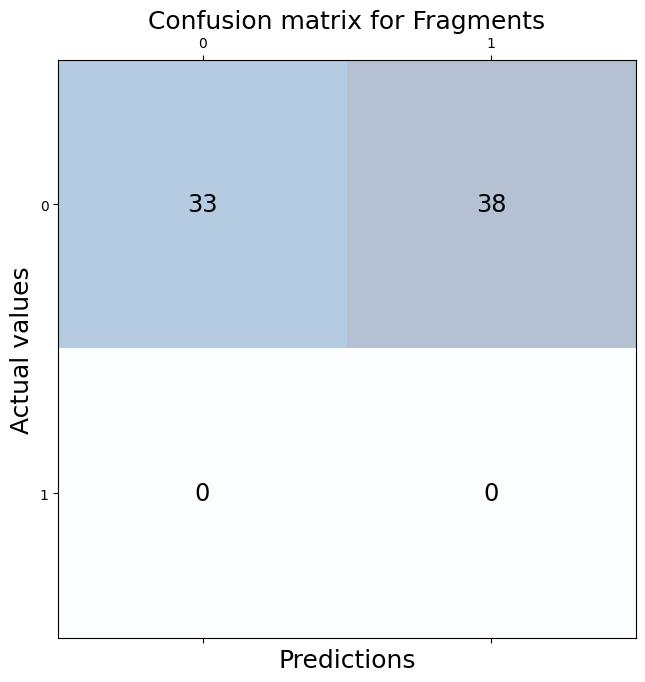

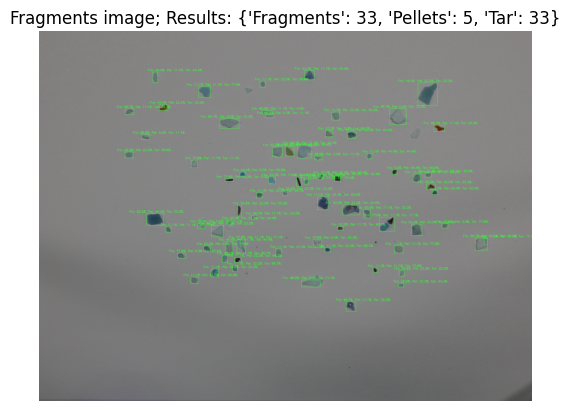

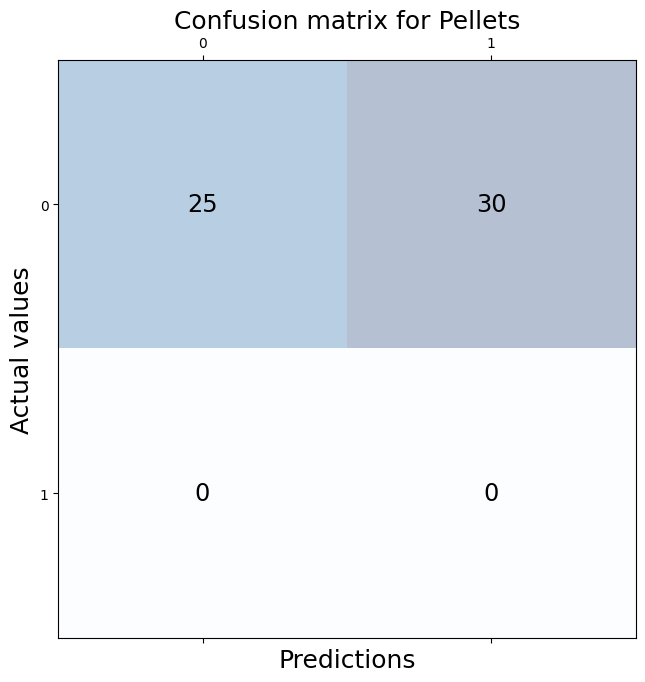

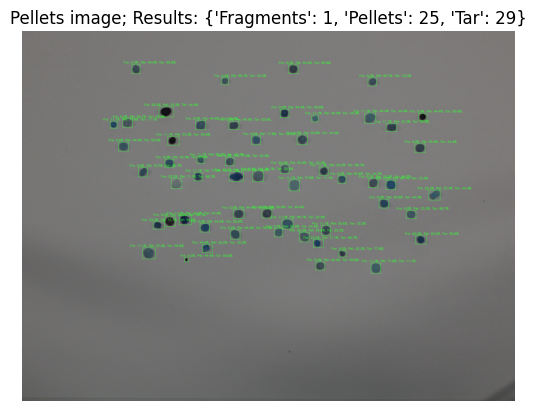

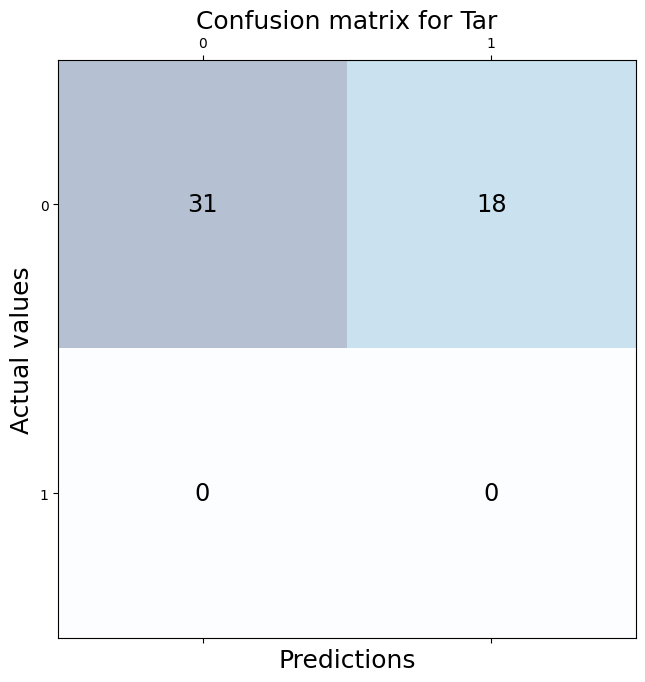

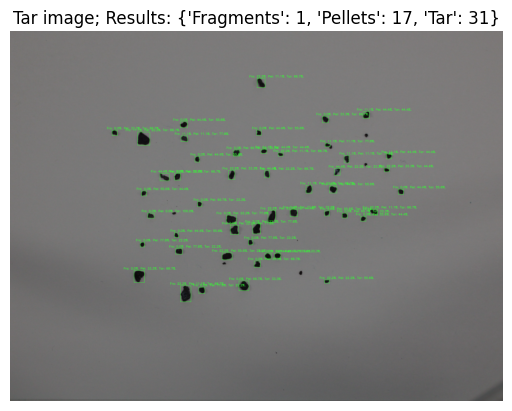

In [317]:
# Ficheros con las imágeres
contrast_image_file_names = {
    "Fragments": "fragment-03-olympus-10-01-2020.JPG",
    "Pellets": "pellet-03-olympus-10-01-2020.JPG",
    "Tar": "tar-03-olympus-10-01-2020.JPG"
}

for microplastic, filename in contrast_image_file_names.items():
    # Carga de la imagen
    microplastic_img = cv2.imread(filename)

    # Conversión a gris
    microplastic_grey = cv2.cvtColor(microplastic_img, cv2.COLOR_BGR2GRAY)

    # Umbralizado OTSU invertido
    ret, microplastic_otsu = cv2.threshold(microplastic_grey, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    

    # Extracción de los contornos externos de los fragmentos
    microplastic_external_contours, microplastic_external_hierarchy = cv2.findContours(microplastic_otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Histograma para la cuenta de los tipos de microplásticos en la imagen
    histogram = {
        "Fragments": 0,
        "Pellets": 0,
        "Tar": 0
    }

    # Filtra los no deseados
    area_threshold = 750
    max_area_threshold = 30000
    filter = lambda contour: cv2.contourArea(contour) > min_area_threshold and cv2.contourArea(contour) < max_area_threshold
    microplastic_filtered_external_contours = [contour for contour in microplastic_external_contours if filter(contour=contour)]

    # Procesamiento para cada contorno y almacenamiento del resultado
    for contour in microplastic_filtered_external_contours:
        if cv2.contourArea(contour) <= 0:
            continue
        histogram[process_contour(contour, microplastic_img, features)] += 1
    
    # Se guarda la imagen pintada
    cv2.imwrite(f"{microplastic}-result-of-detection.jpg", microplastic_img)

    # Cálculo de la matriz de confusion
    true_row = [0,0]
    for key, value in histogram.items():
        if key == microplastic:
            true_row[0] = value
        else:
            true_row[1] += value
    confusion_matrix = [true_row, [0,0]]

    # Muestreo de resultados
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(len(confusion_matrix)):
        for j in range(len(confusion_matrix[0])):
            ax.text(x=j, y=i,s=confusion_matrix[i][j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actual values', fontsize=18)
    plt.title(f"Confusion matrix for {microplastic}", fontsize=18)
    plt.show()
    plt.axis("off")
    plt.title(f"{microplastic} image; Results: {histogram}")
    plt.imshow(microplastic_img)
    plt.show()
    

### Conclusiones

Los resultados muestran una clasificación lejos de ser perfecta. Personalmente, no veo esto como algo sorprendente, puesto que la clasificación de un tipo de objeto se ha hecho reduciendo a un valor promedio un valor de una medida geométrica. Esto trae inconvenientes, por ejemplo, con fragmentos, que los hay de todo tipo de formas y colores. 


También, es importante destacar que el código se ha hecho con un enfoque lo más abstracto y menos a mano posible para el problema, por lo que considero los resultados buenos. 

La manera de mejorar los resultados, al menos, empíricamente, ha sido añadir carácterísticas adicionales. Un salto importante fue al añadir el color que, aunque tarda bastante más en ejecutar, mejoró considerablemente las matrices de confusión del alquitrán y fragmentos. Otra opción sería cambiar los pesos de una característica, por ejemplo, darle el doble de importancia al color.
